# Домашняя работа «Оценка точности модели, переобучение, регуляризация» обновленное

In [226]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

## Задание

**Цель:** закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.

**Описание задания:**

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall.

In [227]:
my_path = r"C:\Users\sveta\Documents\Netology\ML\Лекция_2\athletes.csv"
data = pd.read_csv(my_path)
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


## Этапы работы:

### 1. Преобразуйте данные:
- a. проверьте наличие пропущенных значений. 
Преобразуйте/удалите пропуски по необходимости;


In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [229]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


Проще всего строить модель для бинарной классификации. В нашем случае это предсказание пола. 
Разделение по классам 'male' и 'female' примерно 50/50.

- b. закодируйте категориальные переменные числовыми значениями по необходимости (перекодируем столбцы sport и sex)

In [230]:
df1 = pd.get_dummies(data['sport'])
X = pd.concat([data, df1], axis=1).reindex(data.index)
X.drop('sport', axis=1, inplace=True)
X.drop(['id', 'name', 'nationality', 'sex', 'dob'], axis=1, inplace=True)
X

,height,weight,gold,silver,bronze,aquatics,archery,athletics,badminton,basketball,...,rugby sevens,sailing,shooting,table tennis,taekwondo,tennis,triathlon,volleyball,weightlifting,wrestling
0,1.72,64.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11533,1.64,58.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11534,1.73,63.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11535,1.85,100.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11536,1.60,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [231]:
y = data['sex'].map({'male': 0, 'female': 1})
y

0        0
1        1
2        0
3        0
4        0
        ..
11533    1
11534    1
11535    0
11536    0
11537    0
Name: sex, Length: 10858, dtype: int64

### 2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

Создание и обучение модели

In [234]:
model = LogisticRegression(max_iter=500000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500000)

Получение прогноза

In [235]:
predictions = model.predict_proba(X_test)

Получение значений false и true positive rate для различных значений порога

In [236]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

Отображение ROC-кривой

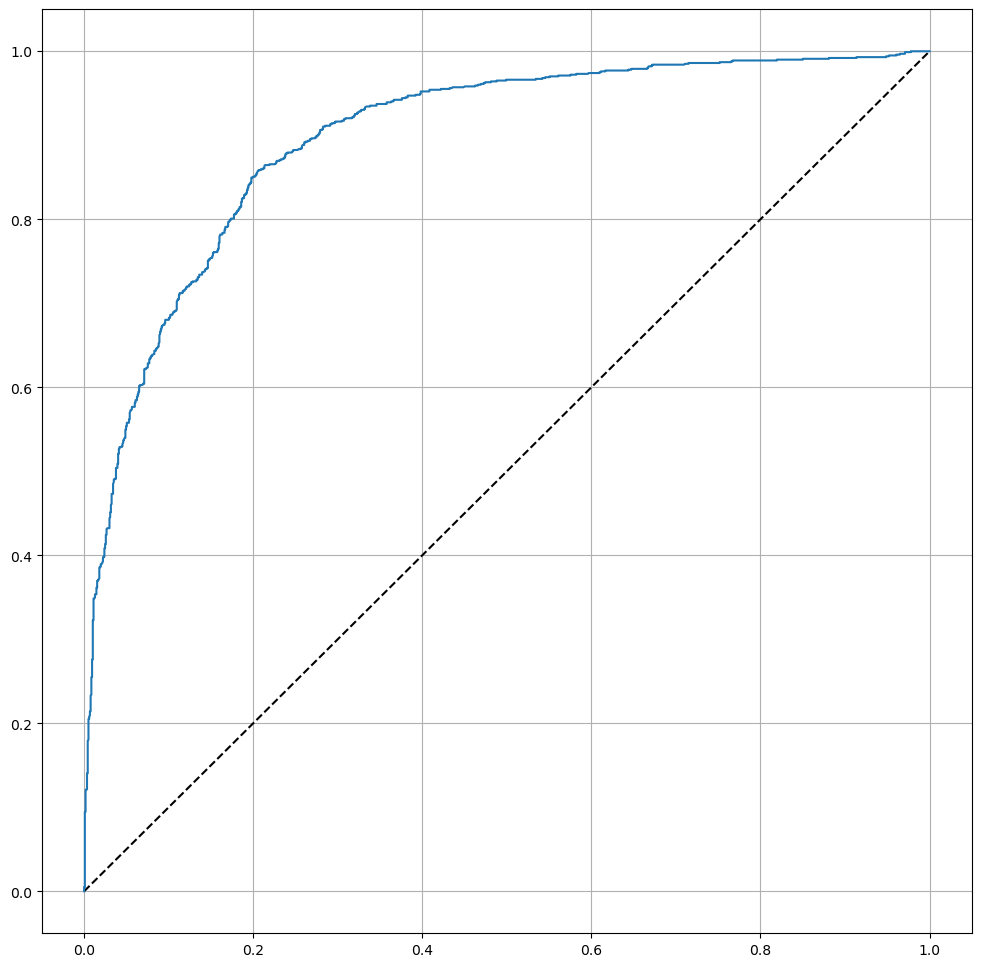

In [237]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.grid()

Модель неплохо справляется с предсказаниями, уточним это, вычислив площадь под кривой

### 4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [238]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions[:, 1])

0.8965823350433881

### 5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [239]:
def tp_fp_fn_tn(threshold = 0.5): # threshold - пороговое значение
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    predictions = model.predict_proba(X_test)
    for predicted_prob, actual in zip( predictions[:, 1], Y_test ):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0
    
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
    
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    return tp, fp, fn, tn 

In [240]:
tp_fp_fn_tn()

(808, 207, 196, 961)

In [241]:
def tpr_fpr(threshold = 0.5):
    tp, fp, fn, tn = tp_fp_fn_tn(threshold)
    
    tpr = tp / (tp + fn) 
    fpr = fp / (fp + tn)
    return tpr, fpr

In [242]:
tpr_fpr()

(0.8047808764940239, 0.17722602739726026)

### 6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

In [243]:
fpr_new = []
tpr_new = []

for t in range(0, 100):
    fpr_new.append(tpr_fpr(t * 0.01)[0])
    tpr_new.append(tpr_fpr(t * 0.01)[1])
        

In [244]:
fpr_new[:5]

[1.0,
 0.9930278884462151,
 0.9920318725099602,
 0.9900398406374502,
 0.9890438247011952]

In [245]:
tpr_new[:5]

[1.0,
 0.940068493150685,
 0.889554794520548,
 0.8467465753424658,
 0.809931506849315]

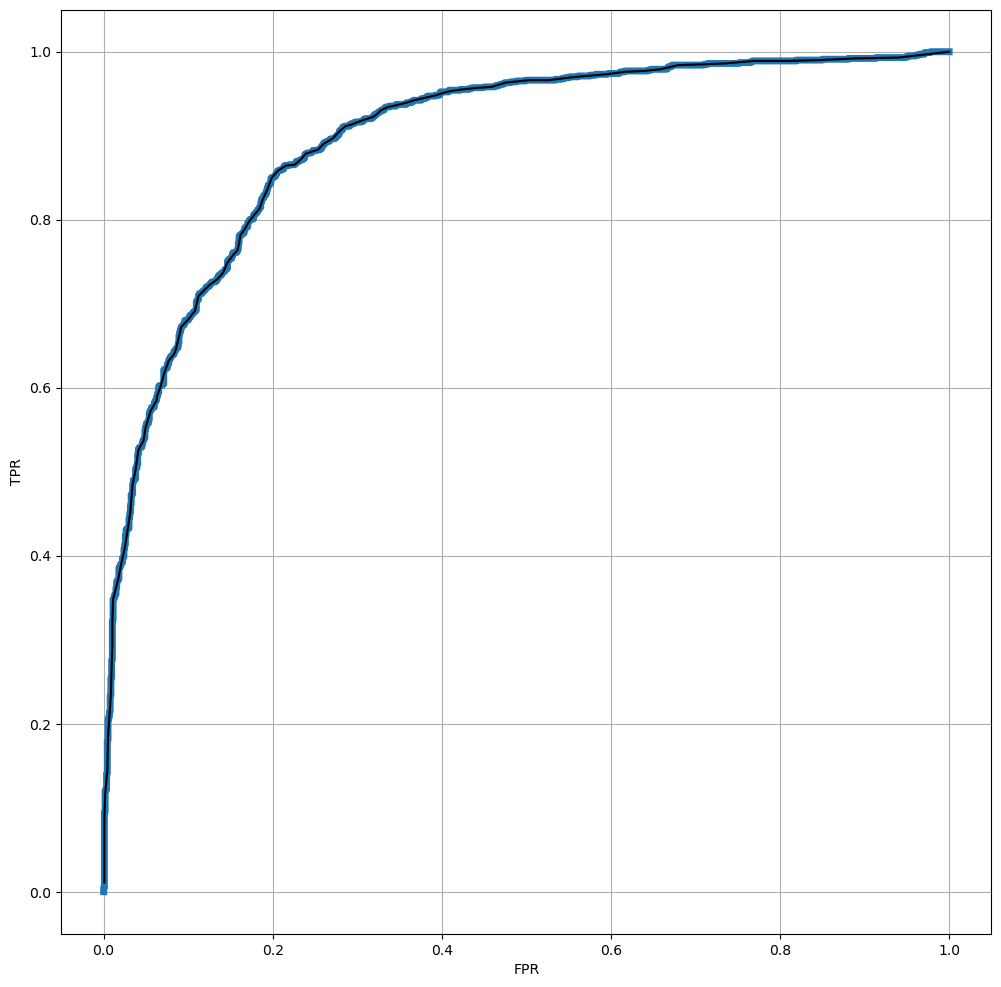

In [246]:
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, linewidth=5)
plt.plot(tpr_new, fpr_new, 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

### 7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

In [247]:
recall = tpr_new
precision = []

for t in range(0, 100):    
    tp, fp, fn, tn = tp_fp_fn_tn(t* 0.01)
    precision.append(tp/(tp + fp))        

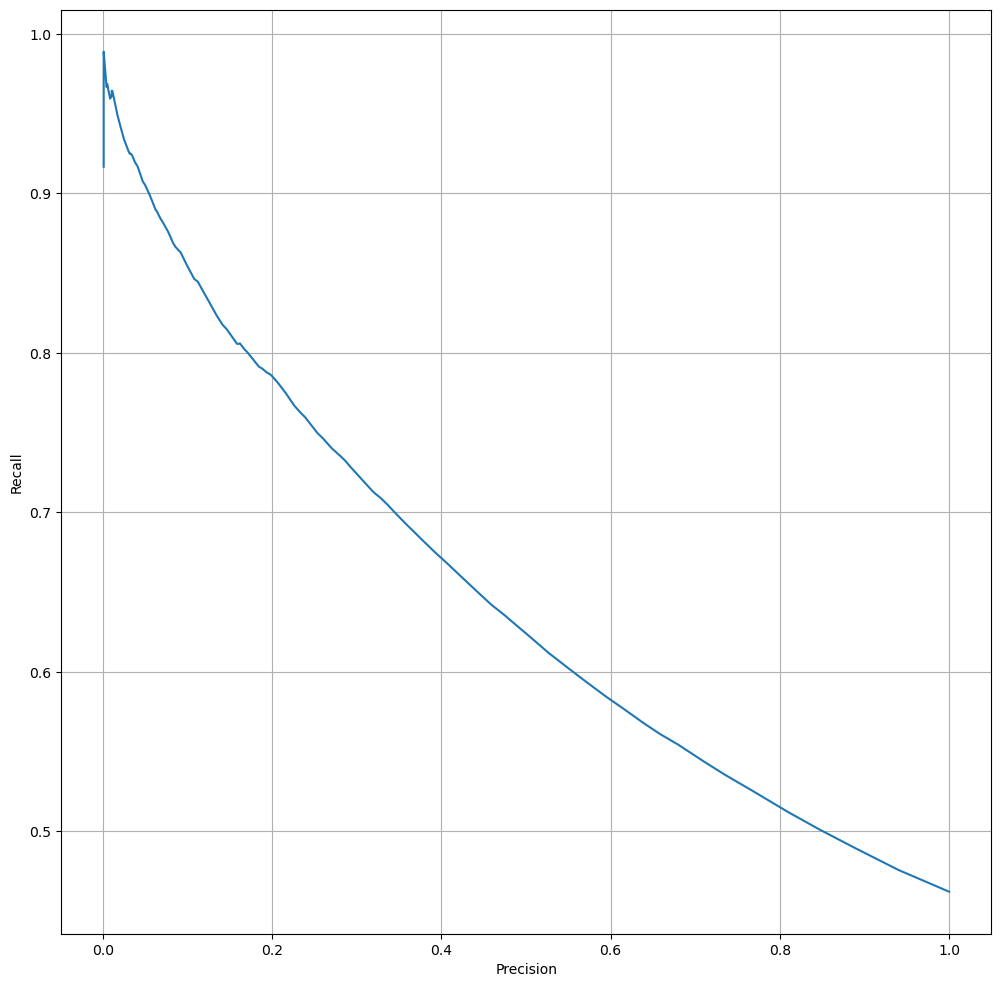

In [248]:
plt.figure(figsize=(12, 12))
plt.plot(tpr_new, precision)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.show()

### 8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [249]:
from sklearn.metrics import roc_auc_score

In [250]:
def roc_auc(tpr, fpr):
    roc_auc = (1 + tpr- fpr) / 2
    return roc_auc

In [251]:
T, F = tpr_fpr(0.5)[0], tpr_fpr(0.5)[1]
roc_auc(T, F)

0.8137774245483818

### 9. Сформулируйте выводы по проделанной работе:
- a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
- b. *может ли ROC-кривая проходить ниже диагонали?

Обученная модель неплохо справляется со своей задачей, предсказывая пол спортсмена с высокой долей вероятности. Это наглядно демонстрирует график ROC-кривой. Она значительно выше прямой $y = x$, означающей случайное угадывание класса.
Площадь под этой кривой 0.897, это почти 90% точности, хотя пересчет этой метрики вручную дает только 81%. 
Сравнение библиотечного и ручного методов подсчета метрик TPR, PFR показывает, что они похожи, так как используют один и тот же принцип. Хотя разница результатов в 9% выглядит немного странно.

Диагональ ROC-кривой соответствует случайному угадыванию класса, когда TPR = FPR. Если ROC-кривая проходит ниже диагонали, то это означает, что классификатор имеет лучшие показатели в FPR, чем TPR, что плохо, и говорит о плохой работе классификатора.


(ROC-кривая может проходить ниже диагонали, если поменять оси, но лучше поменять классификатор)